<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/stable_inpainting/stable_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI Art Exploration**

In this notebook we will use 🤗 Hugging Face transformers and stable diffusion libraries to explore how to segment and edit photos.


### Refs:
- https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/in_painting_with_stable_diffusion_using_diffusers.ipynb#scrollTo=hvdHYdtTu6KA

- https://huggingface.co/blog/mask2former

In [ ]:
!pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate

In [2]:
import inspect
from typing import List, Optional, Union
import ipywidgets as widgets

import numpy as np
import torch

import PIL
from PIL import Image
import gradio as gr
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from diffusers import StableDiffusionInpaintPipeline

## Obtain Models for Segmentaiton and Inpainting

In [ ]:
seg_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
seg_model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")

In [ ]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

# model_path = "stabilityai/stable-diffusion-2-inpainting"


pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

### Let's get an image!

In [9]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

def closest_number(n, m=8):
    """ Obtains closest number to n that is divisble by m """
    return int(n/m) * m

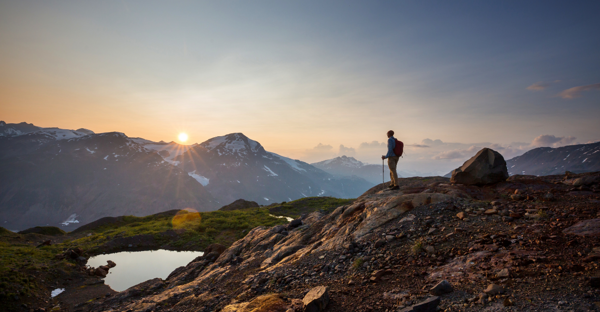

In [12]:
img_url = "https://github.com/itberrios/CV_projects/blob/main/stable_inpainting/assets/Fjord_Cycling.jpg?raw=true"
# img_url = "https://github.com/itberrios/CV_projects/blob/main/stable_inpainting/assets/Bicyclists-at-Glacier-Jacob-W.jpg?raw=true"
img_url = "https://imengine.prod.srp.navigacloud.com/?uuid=27dfa50d-1adb-5367-b8f4-56c2991edaff&type=primary&q=72&width=1200"
img_url = "https://www.oursafetynet.org/wp-content/uploads/2022/12/FB-Promo_Mountains-2.png"
image = download_image(img_url) # .resize((512, 256)) # .resize((1024, 512))
_W, _H = image.size
W, H = closest_number(_W//2), closest_number(_H//2)
image = image.resize((W, H))
image

In [13]:
W, H

(600, 312)

#### Prepare image for input to segmentation model

In [14]:
inputs = seg_processor(image, return_tensors="pt")

with torch.no_grad():
    seg_outputs = seg_model(**inputs)

#### Post Process segmentation model results

In [15]:
seg_prediction = seg_processor.post_process_panoptic_segmentation(seg_outputs, target_sizes=[image.size[::-1]])[0]
print(seg_prediction.keys())

`label_ids_to_fuse` unset. No instance will be fused.


dict_keys(['segmentation', 'segments_info'])


### Display segmentation results

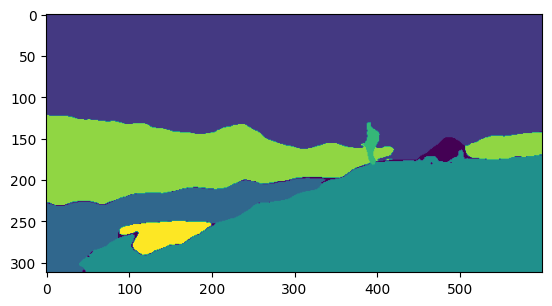

In [16]:
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm

def draw_panoptic_segmentation(model, segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))

    # remove legend for better viz
    # ax.legend(handles=handles)

draw_panoptic_segmentation(seg_model, **seg_prediction)


Let's breakdown these results and understand what the model is giving us.

First let's see the segmented classes:

In [17]:
torch.unique(seg_prediction['segmentation'])

tensor([0, 1, 2, 3, 4, 5, 6], dtype=torch.int32)

Now make things more clear

In [18]:
segment_labels = {}

for segment in seg_prediction['segments_info']:
    segment_id = segment['id']
    segment_label_id = segment['label_id']
    segment_label = seg_model.config.id2label[segment_label_id]

    segment_labels.update({segment_id : segment_label})

segment_labels

{1: 'sky-other-merged',
 2: 'grass-merged',
 3: 'rock-merged',
 4: 'person',
 5: 'mountain-merged',
 6: 'water-other'}

In [44]:
selections = widgets.SelectMultiple(
    options=list(zip(segment_labels.values(), segment_labels.keys())),
    value=[],
    description='Classes',
    disabled=False
)
selections

SelectMultiple(description='Classes', options=(('sky-other-merged', 1), ('grass-merged', 2), ('rock-merged', 3…

In [57]:
tgts = selections.value
tgts

(1, 4, 5)

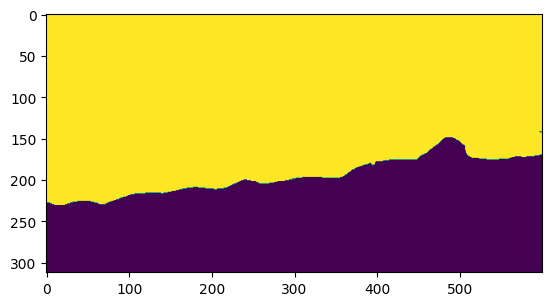

In [58]:
mask = np.array([(seg_prediction['segmentation'] == t).numpy() for t in tgts]).sum(axis=0).astype(np.uint8)*255
plt.imshow(mask);

# Edit the image!

In [59]:
prompt = "a sunset with a mountain backdrop"

guidance_scale=17.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(10) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=Image.fromarray(mask), # ensure mask is same type as image
    height=H,
    width=W,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [60]:
# insert initial image in the list so we can compare side by side
images.insert(0, image)

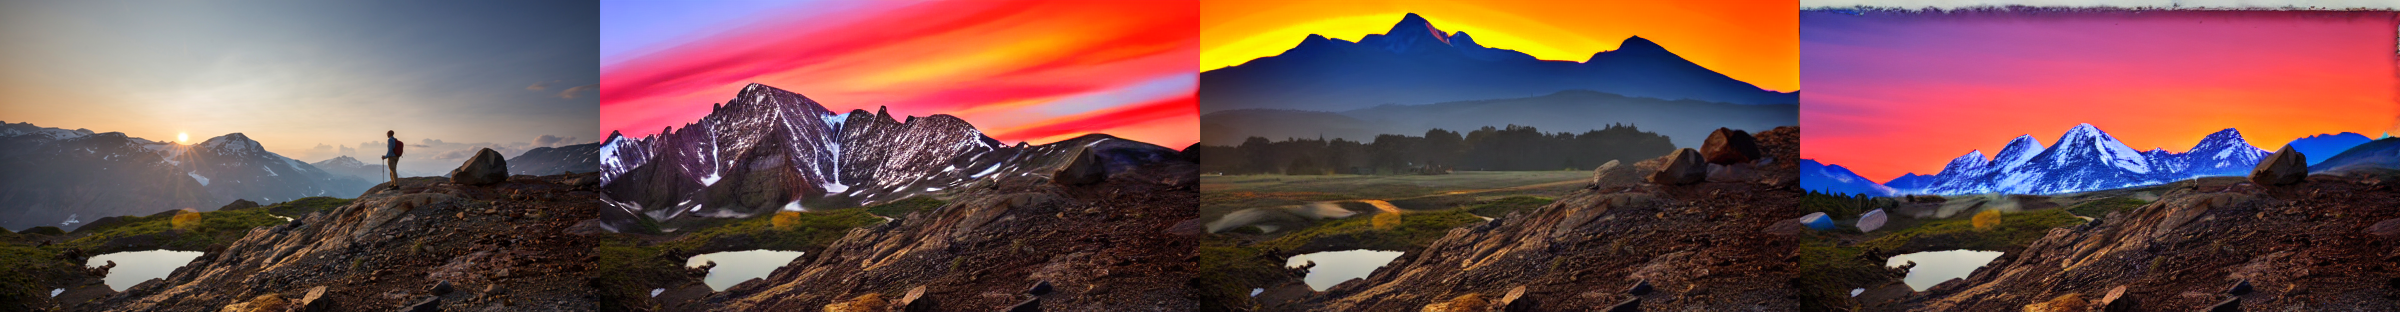

In [68]:
image_grid(images, 1, num_samples + 1)

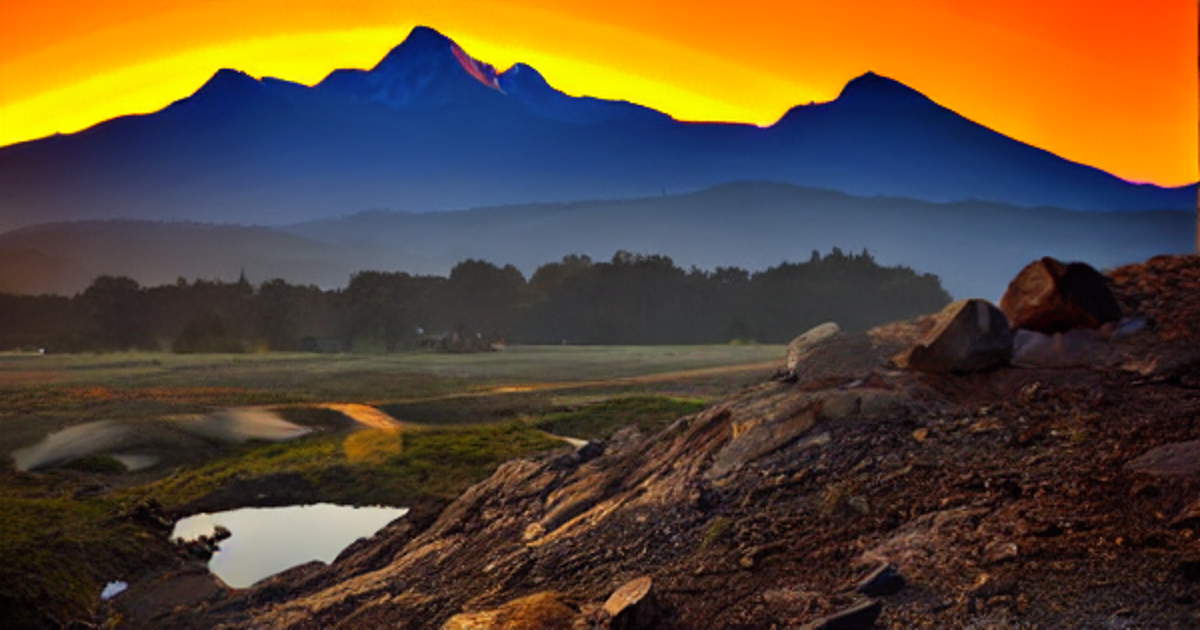

In [70]:
images[2].resize((_W, _H))

### Let's take this a bit further and create something in the foreground

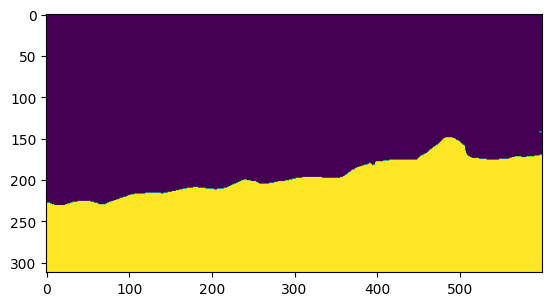

In [65]:
plt.imshow(~mask)

In [66]:
prompt = "a safari with lots of animals"

guidance_scale=17.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(10) # change the seed to get different results

images2 = pipe(
    prompt=prompt,
    image=images[2],
    mask_image=Image.fromarray(~mask), # ensure mask is same type as image
    height=H,
    width=W,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [67]:
images2.insert(0, images[2])

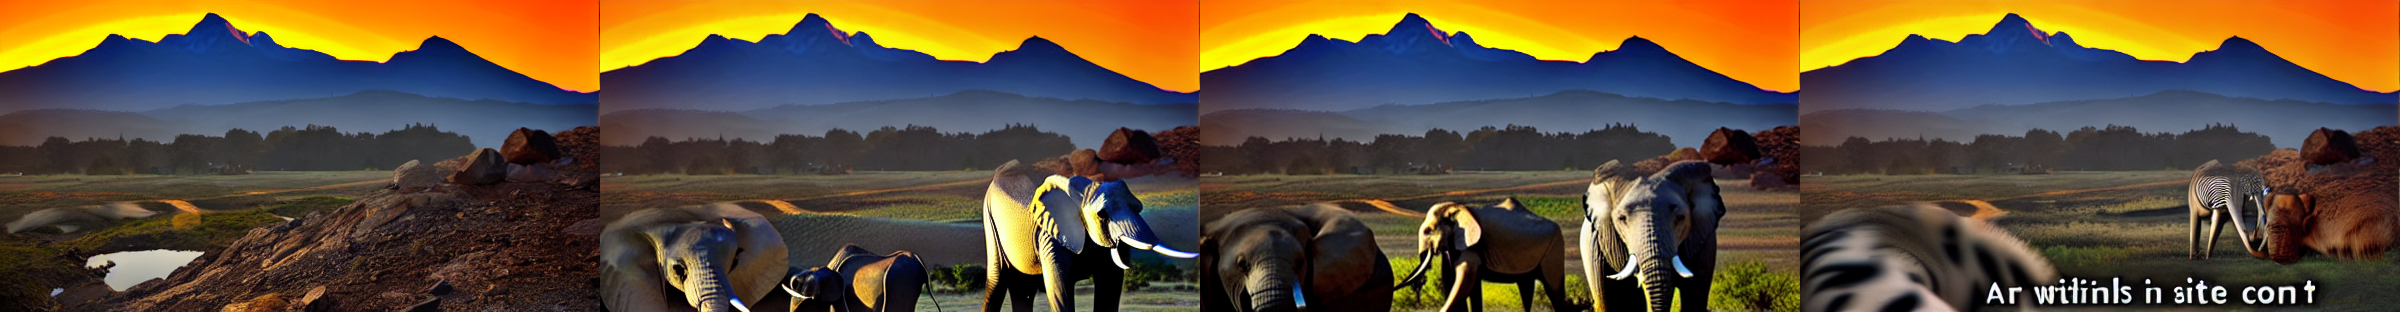

In [69]:
image_grid(images2, 1, num_samples + 1)